In [1]:
!pip install nibabel p_tqdm 2>&1 >/dev/null

from p_tqdm import p_uimap
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import sys
import re
import cv2

In [2]:
!mkdir /datasets -p
from google.colab import drive
drive.mount('/datasets/drive', force_remount=True)

Mounted at /datasets/drive


In [3]:
import os
import random
from pathlib import Path

DATA_DIR = Path("/datasets/drive/MyDrive/UniBa/Computer Science/Projects/Machine Learning/data")
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)
FIRST_RUN = False

In [4]:
subjects = pd.read_csv(DATA_DIR / 'csv/subjects.csv')
clinical_data = pd.read_csv(DATA_DIR / 'csv/clinical-data.csv')
mri_data = pd.read_csv(DATA_DIR / 'csv/mr.csv')
pet_data = pd.read_csv(DATA_DIR / 'csv/pet.csv')
pup_data = pd.read_csv(DATA_DIR / 'csv/pup.csv')

# By default, the CSVs do not contain some information explicitly
# (although the columns have been defined). Thus, here we set them
# to usable values.

pup_data['Date'] = (pup_data['PUP_PUPTIMECOURSEDATA ID']
                        .apply(lambda s: int(s.split('_')[3][1:])))
pup_data['Subject'] = (pup_data['PUP_PUPTIMECOURSEDATA ID']
                           .apply(lambda s: s.split('_')[0]))

clinical_data['Date'] = (clinical_data['ADRC_ADRCCLINICALDATA ID']
                             .apply(lambda s: int(s.split('_')[2][1:])))

pet_data['Tracer'] = (pet_data['XNAT_PETSESSIONDATA ID']
                          .map(lambda x: x.split('_')[1]))

In [5]:
print("Number of subjects:", subjects.shape[0])
print("Number of MRI scans:", mri_data.shape[0])
print("Number of PET scans:", pet_data.shape[0])
print("Number of PUP results:", pup_data.shape[0])

Number of subjects: 1098
Number of MRI scans: 2168
Number of PET scans: 1607
Number of PUP results: 1352


In [6]:
pet_data['Tracer'].value_counts()

PIB     999
AV45    491
FDG     117
Name: Tracer, dtype: int64

In [7]:
(pet_data['Tracer']
    .replace('PIB|AV45', 'Amyloid', regex=True)
    .value_counts(normalize=True))

Amyloid    0.927194
FDG        0.072806
Name: Tracer, dtype: float64

In [8]:
pup_data['tracer'].value_counts()

PIB     935
AV45    417
Name: tracer, dtype: int64

## Labelling the Data

In [9]:
clinical_data.replace({'.': None, np.nan: None}, inplace=True)

In [10]:
import re, yaml
labels = set()
for i in range(1, 6):
    labels = labels.union(clinical_data[f'dx{i}'].unique())
simplified = {str(k): re.match('^(AD dem|Vasc.*? dem|Frontotemporal dem|other mental retarAD demion|(Active )?DLBD|Active PSNP|Dementia)', str(k), re.I) is not None for k in labels}
simplified = {k: v or re.match('^uncertain.*?dem', k) is not None for k, v in simplified.items()}
# We classify uncertain cases as sick

False    4691
True     1533
Name: dementia, dtype: int64

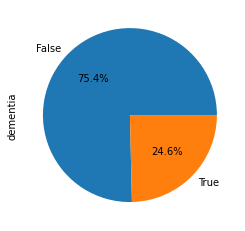

In [11]:
clinical_data['dementia'] = clinical_data[[f'dx{i}' for i in range(1,6)]].replace(simplified).any(axis=1)
clinical_data['dementia'].value_counts().plot.pie(autopct='%1.1f%%')
clinical_data['dementia'].value_counts()

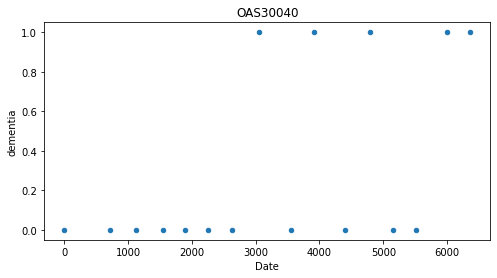

In [12]:
subj = 'OAS30040'
(clinical_data.groupby('Subject')
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x='Date', y='dementia', title=subj, figsize=(8,4)))
plt.show()

In [13]:
clinical_data = clinical_data.sort_values(by=['Subject', 'Date']).reset_index(drop=True)
current_subj = None
for index, row in clinical_data.iterrows():
    if current_subj != row['Subject']:
        current_subj = row['Subject']
        prec = (None, None) # i-2, i-1
        succ = (clinical_data.at[index + 1, 'dementia'] if index + 1 in clinical_data.index and clinical_data.at[index + 1, 'Subject'] == current_subj else None, clinical_data.at[index + 2, 'dementia'] if index + 2 in clinical_data.index and clinical_data.at[index + 2, 'Subject'] == current_subj else None)
    
    if row['dementia'] == True:
        new = prec[1] or any(succ)
    else:
        new = any(prec) and any(succ)
    clinical_data.at[index, 'dementia'] = new
    
    prec = (prec[1], new) # i-1, i
    succ = (succ[1], clinical_data.at[index + 3, 'dementia'] if index + 3 in clinical_data.index and clinical_data.at[index + 3, 'Subject'] == current_subj else None)

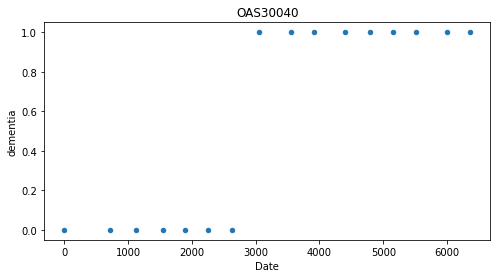

In [14]:
subj = 'OAS30040'
(clinical_data.groupby('Subject')
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x='Date', y='dementia',title=subj, figsize=(8,4)))
plt.show()

In [15]:
labeled_dataset = pup_data.copy()
labeled_dataset.drop(columns=['procType', 'model', 'templateType', 'FSId', 'MRId', 'mocoError', 'regError', 'Centil_fBP_TOT_CORTMEAN', 'Centil_fSUVR_TOT_CORTMEAN', 'Centil_fBP_rsf_TOT_CORTMEAN', 'Centil_fSUVR_rsf_TOT_CORTMEAN'], inplace=True)
labeled_dataset['Label'] = None
for index, row in labeled_dataset.iterrows():
    rows_of_subject = clinical_data.loc[clinical_data['Subject'] == row['Subject']][['Date', 'dementia']]
    rows_of_subject['Date'] = rows_of_subject['Date'].apply(lambda x: abs(x - row['Date']))
    labeled_dataset.at[index,'Label'] = (rows_of_subject.groupby(by='Date', as_index=False) 
                                                        .any()
                                                        .sort_values(by='Date')
                                                        .loc[0]['dementia'])

## Dealing with Class Imbalance

False    0.900148
True     0.099852
Name: Label, dtype: float64

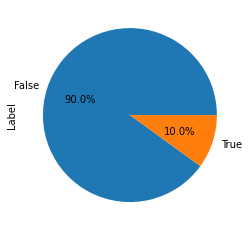

In [16]:
labeled_dataset['Label'].value_counts().plot.pie(autopct='%1.1f%%')
labeled_dataset['Label'].value_counts(normalize=True)

### Random Undersampling

In [17]:
if FIRST_RUN:
    positive = labeled_dataset.loc[labeled_dataset['Label'] == True]
    to_keep = positive
    common_negative = labeled_dataset.loc[(labeled_dataset['Label'] == False) & (labeled_dataset['Subject'].isin(positive['Subject'].unique()))]
    remainder = labeled_dataset[~labeled_dataset['PUP_PUPTIMECOURSEDATA ID'].isin(pd.concat([to_keep, common_negative])['PUP_PUPTIMECOURSEDATA ID'])]
    negative = remainder.sample(205-common_negative.shape[0], random_state=RANDOM_SEED)

    sampled = pd.concat([positive, common_negative, negative])
else:
    sampled = pd.concat([pd.read_csv(DATA_DIR / 'csv/positive.csv'), pd.read_csv(DATA_DIR / 'csv/negative.csv')])

False    205
True     135
Name: Label, dtype: int64

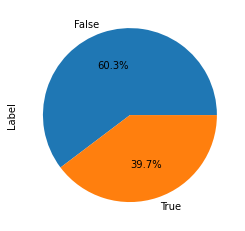

In [18]:
sampled['Label'].value_counts().plot.pie(autopct='%1.1f%%')
sampled['Label'].value_counts()

### Data augmentation

In [19]:
from scipy.ndimage.interpolation import rotate

# This rotation fills the empty space in the corners with the mean of colours from the corner-patch
def rotate_img(img, angle, bg_patch=(5, 5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1], :], axis=(0, 1))
    else:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img


def transform(img, fn):
    transformed = img.copy()
    for f in fn.split("|"):
        grp = re.match(r"^rotate:(-?\d+?)$", f)
        if grp:
            angle = int(grp.group(1))
            for i in range(transformed.shape[0]):
                transformed[i, :, :] = rotate_img(transformed[i, :, :], angle)
        elif f == "flipv":
            transformed = transformed[:, ::-1, :]
        elif f == "fliph":
            transformed = transformed[:, :, ::-1]
        else:
            raise ValueError(f"Illegal 'fn' value '{fn}'")
    return transformed

In [20]:
if FIRST_RUN:
    images = glob.glob(DATA_DIR / 'positive/*.hdr')
    paths = random.choices(images, k=70)
    modimg_df = pd.DataFrame(columns=['image', 'transform'], index=np.arange(0,len(paths)))

    for i, path in enumerate(paths):
        # Need to store both the .nii img and the one with mean,
        # so we can use the .nii for saving later 
        nii_img = nib.load(path)
        img = np.mean(nii_img.dataobj, axis=3)
        transformation_functions = random.choices(['rotate', 'flipv', 'fliph'],
                                            weights=[0.5, 0.25, 0.25],
                                            k=random.randint(1,5))
        transformation_functions = [s + f':{random.randrange(-30, 30)}' if s == 'rotate' else s for s in transformation_functions]
        transform_string = '|'.join(transformation_functions)
        modimg_df.loc[i] = [os.path.basename(path), transform_string]
        # Apply the transformation function(s)
        transformed_img = transform(np.array(img),transform_string)
        to_save_img = nib.Nifti1Image(transformed_img, nii_img.affine)
        # Save the new generated image (as: ORIGINALE_modID.4dfp.img)
        nib.save(to_save_img, DATA_DIR / 'modified' / os.path.basename(path).split('.')[0] + f'_mod{i}.4dfp.nii')
    modimg_df.to_csv('modified-images.csv')
else:
    modimg_df = pd.read_csv(DATA_DIR / 'csv/modified-images.csv')


## Prepare the data

In [21]:
def find_brain_bounding_box(image):
    x,y,w,h = (image.shape[0]+1, image.shape[1]+1, -1, -1)
    for slice in image.T:
        blurred = cv2.GaussianBlur(slice.T, (13, 13), 150)
        blurred *= 255.0 / blurred.max()
        blurred[np.where(blurred < 0)] = 0
        blurred = blurred.astype(np.uint8)
        ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        blurred_thres = cv2.medianBlur(thres, 5)
        contours, hierarchy = cv2.findContours(blurred_thres, 1, 2)
        curr_x, curr_y, curr_w, curr_h = cv2.boundingRect(contours[0])
        w = max(w, curr_x + curr_w)
        h = max(h, curr_y + curr_h)
        x = min(x, curr_x)
        y = min(y, curr_y)
    # provide a small padding around the found box:
    x = max(x - 10, 0)
    y = max(y - 10, 0)
    w = min(w + 10, image.shape[0])
    h = min(h + 10, image.shape[1])
    return x, y, w, h

In [22]:
def normalize(volume):
    """Normalize the volume"""
    volume = np.array(volume)
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [23]:
def resize_to_input_shape(img):
    shape = (128, 128)
    n_frames = 20
    # Starting index to extract the 40 central frames of the third dimension
    index = int(img.shape[2] / 2) - int(n_frames / 2)
    final_img = img[:,:,index : index + n_frames]
    x, y, w, h = find_brain_bounding_box(final_img)
    square_size = max(w - x, h - y)
    to_square = square_size - w + x, square_size - h + y
    miss_x, miss_y = to_square
    x, y = max(int(x - np.floor(miss_x / 2)), 0), max(int(np.floor(y - miss_y / 2)), 0)
    w, h = int(np.floor(w + miss_x / 2)), int(np.floor(h + miss_y / 2))
    return np.array(
        [
            #cv2.resize(frame, shape)
            cv2.resize(frame[x:w,y:h], shape)
            for frame in final_img.T
        ]
    ).T

In [24]:
def process_scan(path):
    """Read and resize volume"""
    try:
        # Read scan
        volume = nib.load(path).get_fdata()
        if len(volume.shape) == 4:
          volume = np.mean(volume, axis=3)
        # Normalize
        volume = normalize(volume)
        # Resize width, height and depth
        volume = resize_to_input_shape(volume)
        return volume
    except OSError:
        print("Error in reading", path, "(file could be damaged)", file=sys.stderr)
        return None

In [25]:
pos_images = [str(s) for s in DATA_DIR.glob('positive/*.hdr')]
neg_images = [str(s) for s in DATA_DIR.glob('negative/*.hdr')]
mod_images = [str(s) for s in DATA_DIR.glob('modified/*.nii')]

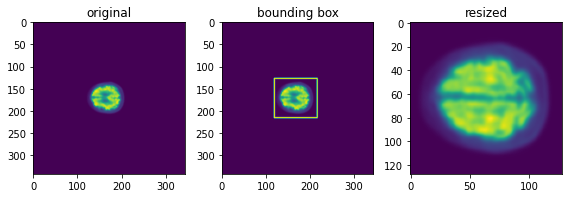

In [29]:
# Testing the resize function
path = list(filter(lambda x: "AV45" in x, pos_images))[0]
pos = np.mean(nib.load(path).get_fdata(), axis=3)
r_pos = process_scan(path)
fig,ax = plt.subplots(1,3, figsize=(8,8))
ax[0].imshow(pos[:,:,int(pos.shape[2]/2)])
ax[0].set_title('original')
index = int(pos.shape[2] / 2) - int(50 / 2)
sliced = pos[:,:,index : index + 50]
rect = find_brain_bounding_box(sliced)
ax[1].imshow(cv2.rectangle(normalize(sliced[:,:,int(sliced.shape[2]/2)]), (rect[0],rect[1]), (rect[2],rect[3]), 1, 2).get())
ax[1].set_title('bounding box')
ax[2].imshow(r_pos[:,:,15])
ax[2].set_title('resized')
plt.tight_layout()
plt.show()

In [37]:
pos = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==20, p_uimap(process_scan, pos_images + mod_images))))
pos_label = np.ones(len(pos)*20, dtype=np.uint8)
neg = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] == 20, p_uimap(process_scan, neg_images))))
neg_label = np.zeros(len(neg)*20, dtype=np.uint8)

In [39]:
x = np.concatenate((*np.concatenate((pos, neg), axis=0),), axis = 2).T
print(x.shape)
y = np.concatenate((pos_label, neg_label), axis=0)

(8080, 128, 128)


In [40]:
print(x.shape, y.shape)

(8080, 128, 128) (8080,)


In [34]:
x[0].shape

(128, 128)

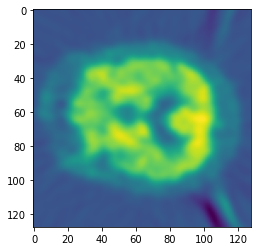

In [43]:
plt.imshow(x[1].T)

In [44]:
from sklearn.model_selection import train_test_split
VAL_SIZE = 0.2
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=VAL_SIZE)

base = DATA_DIR / 'both-folds/validation/'
base.mkdir(parents=True, exist_ok=True)
np.save(base / 'xtrain.npy', x_train)
np.save(base / 'xval.npy', x_val)
np.save(base / 'ytrain.npy', y_train)
np.save(base / 'yval.npy', y_val)

In [46]:
from pathlib import Path
from sklearn.model_selection import StratifiedKFold

base = DATA_DIR / 'both-folds/'
kFold = StratifiedKFold(n_splits=10)
models = []
traintest = kFold.split(x_train,y_train)

for k, (train, test) in enumerate(traintest):
    print("k =", k + 1)

    fold_dir = base / f'fold-{k + 1}'
    fold_dir.mkdir(parents=True, exist_ok=True)

    np.save(fold_dir / 'xtrain.npy', x_train[train])
    np.save(fold_dir / 'ytrain.npy', y_train[train])
    np.save(fold_dir / 'xtest.npy', x_train[test])
    np.save(fold_dir / 'ytest.npy', y_train[test])
    print('Done with ',k + 1)

k = 1
Done with  1
k = 2
Done with  2
k = 3
Done with  3
k = 4
Done with  4
k = 5
Done with  5
k = 6
Done with  6
k = 7
Done with  7
k = 8
Done with  8
k = 9
Done with  9
k = 10
Done with  10
